In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_parquet('output/sentiments.parquet')

# Dataset cleaning
df.dropna(inplace=True)
df = df[(df['review'].apply(lambda x: re.match(r'^[()\[\]{}\'!,.: ]+$', x) is None)) & (df['review'].apply(lambda x: len(x) > 1))]

df['sentiment'] = df['sentiment'].map({
    'Very Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Very Positive': 2
})

#df.rename(columns={'game': 'SteamID'}, inplace=True)
#df = games[['game', 'SteamID']].merge(df, on='SteamID', how='inner').drop(columns=['SteamID'])
df['game'] = df['game'].astype('category')

df

,topic,review,embedding,sentiment,game
0,gameplay mechanics,Excellent game mechanics hampered by really sh...,"[0.02064609, 0.058051355, -0.15955217, -0.0282...",-1,1653100
1,gameplay mechanics,I love the narrator just talking in the backgr...,"[-0.01935661, 0.021597555, -0.18828672, -0.039...",1,1653100
2,gameplay mechanics,The game has received frequent and substantial...,"[0.030498626, 0.035088323, -0.17761268, -0.017...",1,1653100
3,gameplay mechanics,Heliotropism is a roguelike Tree simulator wit...,"[-0.005617, 0.06219709, -0.17552276, -0.042904...",1,1653100
4,narrator and audio,"the narrator is cool at first, then hyper anno...","[0.01688186, 0.010326986, -0.16718766, -0.0392...",-1,1653100
...,...,...,...,...,...
96560,music and sound,Хорошее музыкальное и звуковое сопровождение.,"[-0.035658363, -0.0012977426, -0.1295827, 0.02...",1,2300300
96561,music and sound,"I like the music, it's nice relaxing.","[-0.020432916, 0.03288259, -0.18042335, -0.001...",1,2300300
96562,music and sound,The music is nice relaxing.,"[-0.0041316957, 0.0568026, -0.18956739, 0.0036...",1,2300300
96563,price and value,The asking price might be a bit steep for what...,"[0.012826282, 0.04906256, -0.20521845, 0.02795...",0,2300300


In [2]:
from src.embed import get_embedding, NomicPrefix
from sklearn.metrics.pairwise import cosine_similarity

def get_similars(queries, embeddings, threshold):    
    query_embedding = get_embedding(queries)
    similarities = cosine_similarity(query_embedding, embeddings)
    
    indices = pd.DataFrame(data=np.argwhere(similarities > threshold), columns=['query', 'review'])
    indices['query'] = indices['query'].map(lambda x: queries[x])

    return indices.groupby('query')['review'].apply(list).to_dict()

In [3]:
citations_df = df.drop_duplicates(subset='review')
citation_embeddings = np.vstack(citations_df['embedding'].values)

#all_topics = df['topic'].unique()
#topics_embeddings = get_embedding(list(all_topics))
#pd.DataFrame(data=topics_embeddings, index=all_topics).to_parquet('output/topics.parquet')

all_topics = pd.read_parquet('output/topics.parquet')
topics_embeddings = all_topics.values
all_topics = all_topics.index

In [4]:
len(all_topics)

6449

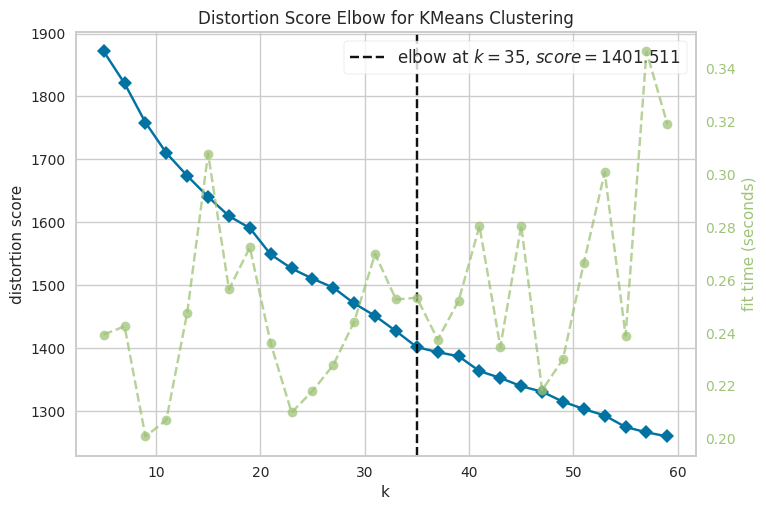

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.set_loglevel('error')

model = KMeans()
visualizer = KElbowVisualizer(model, k=range(5, 60, 2))

topics_clustering_embeddings = get_embedding(list(all_topics), prefix=NomicPrefix.CLUSTERING)

visualizer.fit(topics_clustering_embeddings)
visualizer.show()

In [24]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_).fit_predict(topics_clustering_embeddings)
tsne = TSNE(n_components=2, verbose=1, max_iter=500).fit_transform(topics_clustering_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6449 samples in 0.004s...
[t-SNE] Computed neighbors for 6449 samples in 0.252s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6449
[t-SNE] Computed conditional probabilities for sample 2000 / 6449
[t-SNE] Computed conditional probabilities for sample 3000 / 6449
[t-SNE] Computed conditional probabilities for sample 4000 / 6449
[t-SNE] Computed conditional probabilities for sample 5000 / 6449
[t-SNE] Computed conditional probabilities for sample 6000 / 6449
[t-SNE] Computed conditional probabilities for sample 6449 / 6449
[t-SNE] Mean sigma: 0.222245
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.908066
[t-SNE] KL divergence after 500 iterations: 1.580053


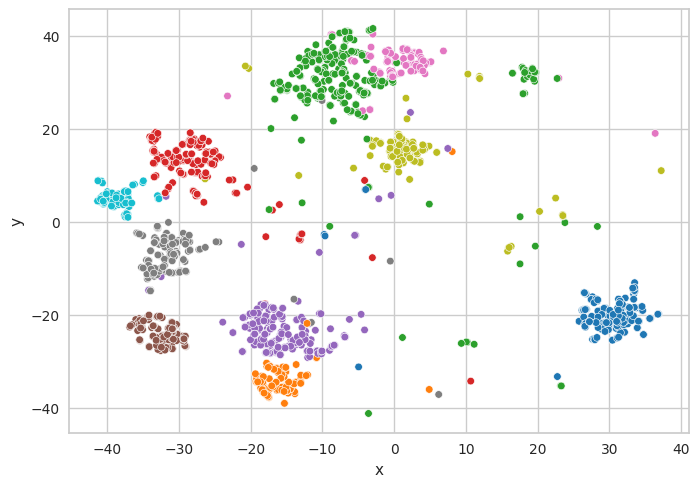

In [34]:
# Select 10 random clusters
df_cluster = pd.DataFrame(data=tsne, columns=['x', 'y'])
df_cluster['cluster'] = kmeans

random_clusters = np.random.choice(np.unique(kmeans), 10)
df_cluster = df_cluster[df_cluster['cluster'].isin([2, 5, 7, 8, 9, 14, 15, 25, 28, 30])]

sns.scatterplot(data=df_cluster, x='x', y='y', hue='cluster', palette='tab10', s=30, legend=False)
plt.savefig('output/out/clusters.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [16]:
# take 10 random clusters
clusters = np.random.choice(np.unique(kmeans), 10)
clusters

array([10,  9, 19,  6, 12, 32, 24, 14, 23, 23], dtype=int32)

In [4]:
def search_similars(queries):
    similars_by_text = get_similars(queries, citation_embeddings, 0.8)
    similars_by_topic = get_similars(queries, topics_embeddings, 0.85)

    results = {}
    for query in queries:
        sim_a = citations_df.iloc[similars_by_text.get(query, [])]

        included_topics = all_topics[similars_by_topic.get(query, [])]
        sim_b = df[df['topic'].isin(included_topics)]

        # Merge and drop duplicates
        sim = pd.concat([sim_a, sim_b]).drop_duplicates(subset='review')
        results[query] = sim[['review', 'sentiment', 'game']]
    
    return results

In [5]:
import json

queries: dict = json.load(open('data/queries.json'))

In [6]:
results = {
    category: search_similars(q)
    for category, q in queries.items()
}

In [ ]:
results_df = pd.concat([
    pd.concat([d.assign(category=category, query=q) for q, d in cat_q.items()])
    for category, cat_q in results.items()
])

results_df['query'] = results_df['query'].astype('category')
results_df['category'] = results_df['category'].astype('category')

results_df.info()

In [8]:
def get_table(results, agg_fn):
    df = pd.DataFrame()
    for category, queries in results.items():
        for query, citations in queries.items():
            #df[(category, query)] = agg_fn(citations)
            df[query] = agg_fn(citations)
    #df.columns = pd.MultiIndex.from_tuples(df.columns, names=['category', 'query'])
    return df

counts = get_table(results, lambda x: x['game'].value_counts()).sort_index()
means = get_table(results, lambda x: x.groupby('game', observed=False)['sentiment'].mean()).sort_index()

# Select games with more than 10 hits in almost 2 categories
selected_games = counts[counts[counts >= 10].count(axis=1) > 1].index

# Hide values between -0.5 and 0.5 and mean support less than 10
means = means[(means.abs() > 0.5) & (counts >= 10)].loc[selected_games].dropna(how='all', axis=1).dropna(how='all', axis=0)

In [14]:
games = pd.read_csv('./data/Game List - Final.csv')
games = games.dropna(subset=['SteamID']).rename(columns={'List (merge)': 'game'})
games = games[games['Final decision'] == 'Yes']

games['SteamID'] = games['SteamID'].astype(int).astype(str)
games.set_index('SteamID', inplace=True)
games = games[['game']]
games = games.loc[selected_games]

games.to_latex('output/games.tex')

In [ ]:
from itertools import combinations
from collections import defaultdict

results_df = results_df[results_df['game'].isin(selected_games)]
grouped = results_df.groupby('query', observed=True)
cooccurrence = defaultdict(int)

# Count co-occurrences of reviews between query pairs
for (query1, reviews1), (query2, reviews2) in combinations(grouped, 2):
    shared_reviews = pd.merge(reviews1, reviews2, on='review', how='inner')
    cooccurrence[(query2, query1)] = shared_reviews

cooccurrence = pd.DataFrame([
    {'query1': q1, 'query2': q2, 'shared_reviews': count}
    for (q1, q2), count in cooccurrence.items()
])

cooccurrence = cooccurrence[cooccurrence['shared_reviews'].apply(lambda x: len(x) >= 10)]

cooccurrence['n'] = cooccurrence['shared_reviews'].apply(len)
cooccurrence['mean'] = cooccurrence['shared_reviews'].apply(lambda x: np.mean(x['sentiment_x']))
cooccurrence['top-3'] = cooccurrence['shared_reviews'].apply(lambda x: x.groupby('game_x', observed=True)['sentiment_x'].mean().nlargest(3).index.tolist())

cooccurrence

In [11]:
top_3 = pd.DataFrame(
    index=pd.MultiIndex.from_frame(cooccurrence[['query1', 'query2']]),
    columns=['1', '2', '3'],
    data=cooccurrence['top-3'].tolist()
).sort_index()

top_3.style.to_latex(
    buf='output/out/top-3.tex',
    position='t',
    position_float='centering',
    caption='Top 3 games with highest sentiment for each query pair',
    label='tab:top-3',
    hrules=True,
)

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(
    cooccurrence.pivot(index='query1', columns='query2', values='n'),
    annot=True,
    cmap='Spectral_r',
    fmt='.0f',
    ax=axs[0],
    center=0
)

sns.heatmap(
    cooccurrence.pivot(index='query1', columns='query2', values='mean'),
    annot=True,
    fmt='.2f',
    robust=True,
    cmap='Spectral_r',
    ax=axs[1],
    center=0,
)

axs[0].set_title('Number of co-occurrenced citations')
axs[1].set_title('Mean sentiment of co-occurrenced citations')
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')

os.makedirs('output/out', exist_ok=True)
plt.tight_layout()
plt.savefig('output/out/cooccurrences.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
# Sort columns by non-null values
means = means[means.count().sort_values(ascending=True).index]

# Sort index by non-null values
means = means.loc[means.count(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(15, 10))
sns.heatmap(means.T, annot=True, cmap='Spectral_r', fmt='.1f')
plt.xlabel('Game')
plt.ylabel('Query')
plt.savefig('output/out/mean-sentiment.pdf', format='pdf', bbox_inches='tight')

plt.show()